# Bayesian Optimization for Hyperparameter Tuning

In [25]:
#!pip install tpot
#!pip install scikit-optimize
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import zipfile
import urllib.request
import io
import warnings
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, KFold 
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from skopt import BayesSearchCV, plots
from skopt.space import Real, Categorical, Integer

In [148]:
# load processed data
#train_median = pd.read_csv('../data_processing/train/train_valid_median.csv')
#train_latest = pd.read_csv('../data_processing/train/train_valid_latest.csv')
#train_latest = train_latest.drop(train_latest.columns[0:10], axis=1)
# append "_2" to each column name in train_latest
#train_latest.columns = [str(col) + '_2' for col in train_latest.columns]
# merge train_median and train_latest
#train = pd.concat([train_median, train_latest], axis=1)

In [26]:
train = pd.read_csv('../data_processing/train/train_valid_latest.csv')
valid = pd.read_csv('../data_processing/valid/valid_latest.csv')
test = pd.read_csv('../data_processing/test/test_latest.csv')

In [27]:
valid.head(10)

,id,subject_id,hadm_id,admittime,dischtime,deathtime,StudyDate,StudyTime,readmitted_within_30days,stay_len,...,CARDIAC DRUGS,PRE-NATAL VITAMINS,ANESTHETICS,ANTIBIOTICS,ANTIHYPERGLYCEMICS,SEDATIVE/HYPNOTICS,ANTIDOTES,AUTONOMIC DRUGS,VITAMINS,BIOLOGICALS
0,10582595_20690213,10582595,20690213,2110-02-09 20:41:00,2110-02-17 15:40:00,NaN,2110-02-16,50133.578,0,-0.499496,...,0.476808,-0.020743,3.972010,0.212490,-0.347064,-0.071276,-0.049856,-0.29886,-0.377153,-0.303435
1,14385035_20480421,14385035,20480421,2110-02-23 14:28:00,2110-03-11 17:29:00,NaN,2110-02-28,214324.437,0,0.220385,...,0.900902,-0.020743,-0.508787,0.908073,0.001688,-0.475464,-0.049856,-0.29886,-0.377153,1.514828
2,14693421_22750388,14693421,22750388,2110-04-12 23:26:00,2110-05-02 15:12:00,NaN,2110-04-22,221813.859,0,0.460345,...,-0.371378,-0.020743,0.238012,-0.483094,-0.347064,-0.475464,-0.049856,-0.29886,-0.377153,-0.303435
3,10100035_20559195,10100035,20559195,2110-04-22 09:52:00,2110-05-09 16:20:00,NaN,2110-05-07,81034.000,0,0.300372,...,-0.371378,-0.020743,-0.508787,-0.309198,-0.347064,-0.475464,-0.049856,-0.29886,-0.377153,-0.303435
4,19777874_25401731,19777874,25401731,2110-09-17 22:47:00,2110-09-20 19:23:00,NaN,2110-09-19,35531.125,0,-0.899429,...,-0.371378,-0.020743,0.238012,-0.656990,-0.347064,-0.475464,-0.049856,-0.29886,-0.377153,-0.303435
5,14485229_21106903,14485229,21106903,2110-09-30 14:00:00,2110-10-15 14:45:00,NaN,2110-10-14,85546.343,0,0.140398,...,0.052715,-0.020743,-0.508787,-0.135302,-0.347064,-0.071276,-0.049856,-0.29886,-0.377153,-0.303435
6,15545381_21463547,15545381,21463547,2110-12-01 22:29:00,2110-12-12 17:37:00,NaN,2110-12-12,131739.562,0,-0.259535,...,-0.371378,-0.020743,0.238012,-0.830886,-0.347064,-0.071276,-0.049856,-0.29886,-0.377153,-0.303435
7,19569832_26373484,19569832,26373484,2111-02-18 16:13:00,2111-03-08 11:15:00,NaN,2111-03-04,85014.031,0,0.300372,...,0.052715,-0.020743,0.238012,0.212490,-0.347064,-0.475464,-0.049856,-0.29886,0.731419,-0.303435
8,10076958_24419799,10076958,24419799,2111-03-15 07:15:00,2111-03-27 13:00:00,NaN,2111-03-24,101152.000,0,-0.099562,...,-0.371378,-0.020743,0.238012,-0.830886,-0.347064,2.353850,-0.049856,-0.29886,-0.377153,-0.303435
9,18638427_28302783,18638427,28302783,2111-03-18 21:33:00,2111-04-11 21:30:00,NaN,2111-04-08,155814.000,0,0.780292,...,-0.371378,-0.020743,0.238012,-0.830886,-0.347064,-0.475464,-0.049856,-0.29886,1.839990,-0.303435


In [20]:
#import sys
#sys.path.append('../code_base') # relative path to code base
#from adjust_imbl import adjust_imbl
#X_train, y_train = adjust_imbl(X_train, y_train)

Original dataset shape Counter({0: 7651, 1: 1620})
Resampled dataset shape Counter({0: 7651, 1: 7651})


In [28]:
# separate response and features
X_train = train.drop(train.columns[0:9], axis=1)
y_train = train["readmitted_within_30days"]
X_valid = valid.drop(valid.columns[0:9], axis=1)
y_valid = valid["readmitted_within_30days"]
X_test = test.drop(test.columns[0:8], axis=1)

In [29]:
# logistic regression
# BayesSearchCV
lr = LogisticRegression(solver='liblinear', max_iter=100)
params = {
    'penalty': ['l1', 'l2'],
    'C': Real(1e-6, 1e+6, prior='log-uniform')
}
opt = BayesSearchCV(lr, params, n_iter=50, cv=5, scoring='roc_auc', n_jobs=-1)
opt.fit(X_train, y_train)
print("Best params: ", opt.best_params_)
print("Best AUC: %.4f" % opt.best_score_)

Best params:  OrderedDict([('C', 0.013297406247056288), ('penalty', 'l2')])
Best AUC: 0.7491


array([[<Axes: xlabel='C', ylabel='Partial dependence'>, <Axes: >],
       [<Axes: xlabel='C', ylabel='penalty'>,
        <Axes: xlabel='penalty', ylabel='Partial dependence'>]],
      dtype=object)

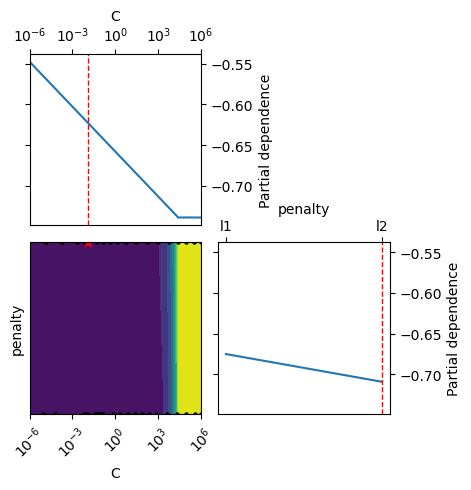

In [30]:
# objective plot
plots.plot_objective(opt.optimizer_results_[0])

array([[<Axes: xlabel='C', ylabel='Number of samples'>, <Axes: >],
       [<Axes: xlabel='C', ylabel='penalty'>,
        <Axes: xlabel='penalty', ylabel='Number of samples'>]],
      dtype=object)

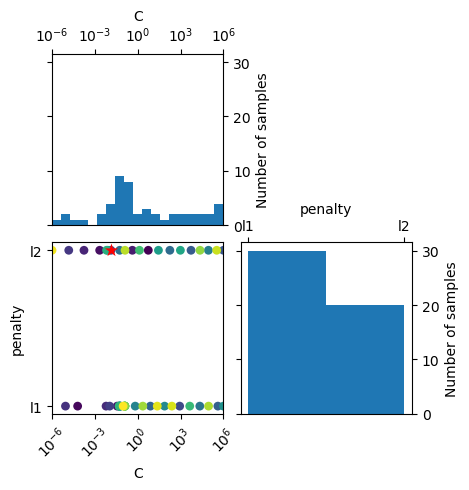

In [31]:
# evaluation plot
plots.plot_evaluations(opt.optimizer_results_[0])

In [146]:
# Linear Discriminant Analysis
lda = LinearDiscriminantAnalysis(solver='lsqr')
params = {
    'shrinkage': Real(0, 1, prior='uniform')
}
opt = BayesSearchCV(lda, params, n_iter=50, cv=5, scoring='roc_auc', n_jobs=-1)
opt.fit(X_train, y_train)
print("Best params: ", opt.best_params_)
print("Best AUC: %.4f" % opt.best_score_)

Best params:  OrderedDict([('shrinkage', 0.12764135355793202)])
Best AUC: 0.7454


<Axes: xlabel='shrinkage', ylabel='Partial dependence'>

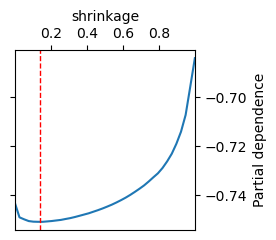

In [36]:
# objective plot
plots.plot_objective(opt.optimizer_results_[0])

<Axes: xlabel='shrinkage', ylabel='Number of samples'>

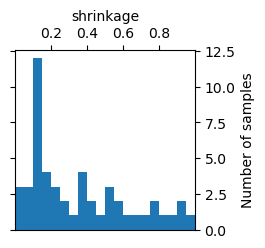

In [37]:
# evaluation plot
plots.plot_evaluations(opt.optimizer_results_[0])

In [38]:
# Quadratic Discriminant Analysis
qda = QuadraticDiscriminantAnalysis()
params = {
    'reg_param': Real(0, 1, prior='uniform')
}
opt = BayesSearchCV(qda, params, n_iter=50, cv=5, scoring='roc_auc', n_jobs=-1)
opt.fit(X_train, y_train)
print("Best params: ", opt.best_params_)
print("Best AUC: %.4f" % opt.best_score_)

/Users/zxyao5148/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/zxyao5148/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/zxyao5148/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/zxyao5148/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/zxyao5148/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/zxyao5148/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear

Best params:  OrderedDict([('reg_param', 0.03839424798540189)])
Best AUC: 0.7077


<Axes: xlabel='reg_param', ylabel='Partial dependence'>

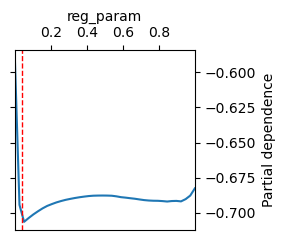

In [39]:
# objective plot
plots.plot_objective(opt.optimizer_results_[0])

<Axes: xlabel='reg_param', ylabel='Number of samples'>

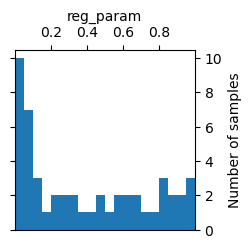

In [40]:
# evaluation plot
plots.plot_evaluations(opt.optimizer_results_[0])

In [41]:
# Naive Bayes
nb = GaussianNB()
params = {
    'var_smoothing': Real(1e-9, 1e-7, prior='log-uniform')
}
opt = BayesSearchCV(nb, params, n_iter=50, cv=5, scoring='roc_auc', n_jobs=-1)
opt.fit(X_train, y_train)
print("Best params: ", opt.best_params_)
print("Best AUC: %.4f" % opt.best_score_)

Best params:  OrderedDict([('var_smoothing', 1.561323861635709e-08)])
Best AUC: 0.5038


<Axes: xlabel='var_smoothing', ylabel='Partial dependence'>

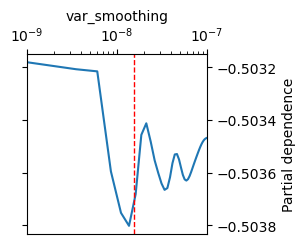

In [42]:
# objective plot
plots.plot_objective(opt.optimizer_results_[0])

<Axes: xlabel='var_smoothing', ylabel='Number of samples'>

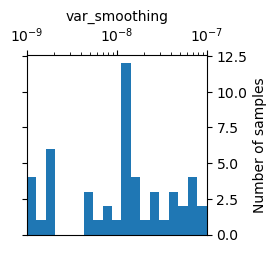

In [43]:
# evaluation plot
plots.plot_evaluations(opt.optimizer_results_[0])

In [64]:
# K-Nearest Neighbors
knn = KNeighborsClassifier()
params = {
    'n_neighbors': Integer(1, 100)
}
opt = BayesSearchCV(knn, params, n_iter=50, cv=5, scoring='roc_auc', n_jobs=-1)
opt.fit(X_train, y_train)
print("Best params: ", opt.best_params_)
print("Best AUC: %.4f" % opt.best_score_)

Best params:  OrderedDict([('n_neighbors', 72)])
Best AUC: 0.7116


<Axes: xlabel='n_neighbors', ylabel='Partial dependence'>

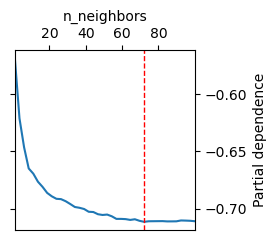

In [65]:
# objective plot
plots.plot_objective(opt.optimizer_results_[0])

<Axes: xlabel='n_neighbors', ylabel='Number of samples'>

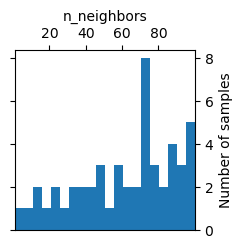

In [66]:
# evaluation plot
plots.plot_evaluations(opt.optimizer_results_[0])

In [ ]:
# Support Vector Machine
svm = SVC(probability=True)
params = {
    'C': Real(1e-6, 1e+6, prior='log-uniform'),
    'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
    'degree': Integer(1, 8)
}
opt = BayesSearchCV(svm, params, n_iter=50, cv=5, scoring='roc_auc', n_jobs=-1)
opt.fit(X_train, y_train)
print("Best params: ", opt.best_params_)
print("Best AUC: %.4f" % opt.best_score_)

In [ ]:
# objective plot
plots.plot_objective(opt.optimizer_results_[0])

In [ ]:
# evaluation plot
plots.plot_evaluations(opt.optimizer_results_[0])

In [133]:
# Decision Tree
dt = DecisionTreeClassifier()
params = {
    'max_depth': Integer(1, 100),
    'min_samples_split': Integer(2, 100),
    'min_samples_leaf': Integer(1, 100)
}
opt = BayesSearchCV(dt, params, n_iter=50, cv=5, scoring='roc_auc', n_jobs=-1)
opt.fit(X_train, y_train)
print("Best params: ", opt.best_params_)
print("Best AUC: %.4f" % opt.best_score_)

Best params:  OrderedDict([('max_depth', 100), ('min_samples_leaf', 14), ('min_samples_split', 99)])
Best AUC: 0.8947


array([[<Axes: xlabel='max_depth', ylabel='Partial dependence'>,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='min_samples_leaf'>,
        <Axes: xlabel='min_samples_leaf', ylabel='Partial dependence'>,
        <Axes: >],
       [<Axes: xlabel='max_depth', ylabel='min_samples_split'>,
        <Axes: xlabel='min_samples_leaf'>,
        <Axes: xlabel='min_samples_split', ylabel='Partial dependence'>]],
      dtype=object)

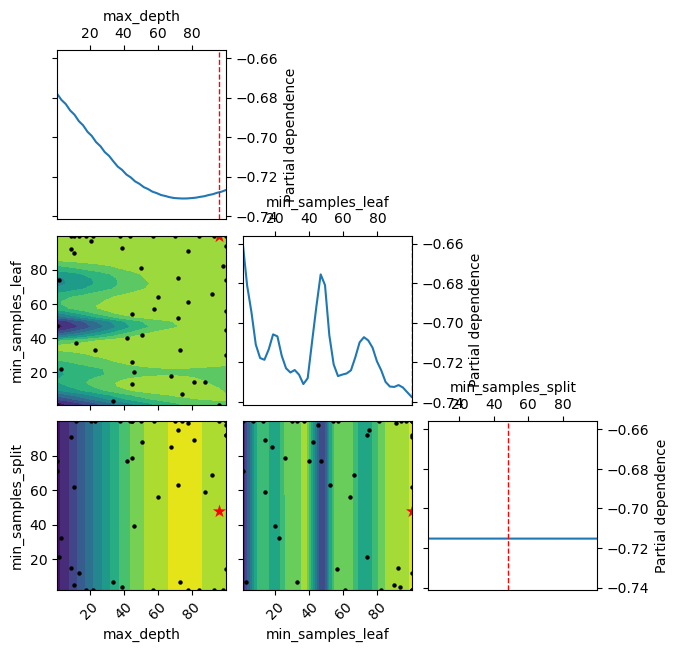

In [47]:
# objective plot
plots.plot_objective(opt.optimizer_results_[0])

array([[<Axes: xlabel='max_depth', ylabel='Number of samples'>, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='min_samples_leaf'>,
        <Axes: xlabel='min_samples_leaf', ylabel='Number of samples'>,
        <Axes: >],
       [<Axes: xlabel='max_depth', ylabel='min_samples_split'>,
        <Axes: xlabel='min_samples_leaf'>,
        <Axes: xlabel='min_samples_split', ylabel='Number of samples'>]],
      dtype=object)

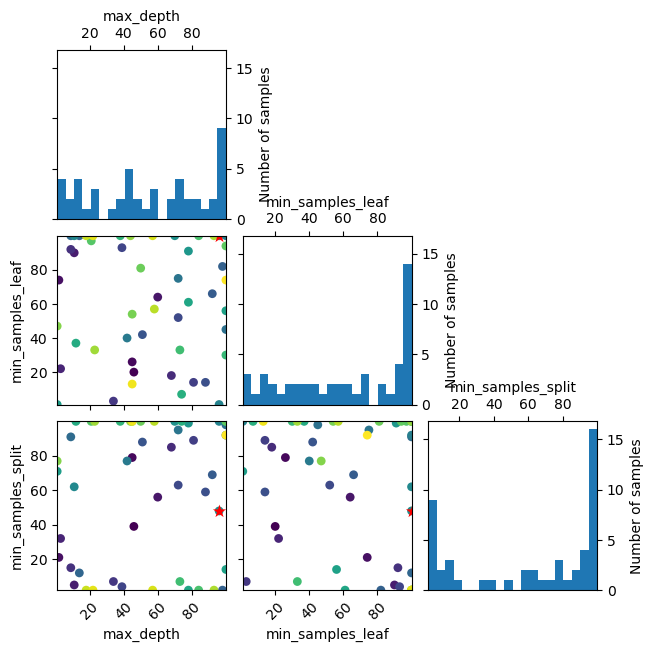

In [48]:
# evaluation plot
plots.plot_evaluations(opt.optimizer_results_[0])

In [49]:
# Bagging
bag = BaggingClassifier()
params = {
    'n_estimators': Integer(10, 100),
    'max_samples': Real(0.1, 1, prior='uniform'),
    'max_features': Real(0.1, 1, prior='uniform')
}
opt = BayesSearchCV(bag, params, n_iter=50, cv=5, scoring='roc_auc', n_jobs=-1)
opt.fit(X_train, y_train)
print("Best params: ", opt.best_params_)
print("Best AUC: %.4f" % opt.best_score_)

Best params:  OrderedDict([('max_features', 0.5938497291209198), ('max_samples', 1.0), ('n_estimators', 100)])
Best AUC: 0.7776


array([[<Axes: xlabel='max_features', ylabel='Partial dependence'>,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='max_samples'>,
        <Axes: xlabel='max_samples', ylabel='Partial dependence'>,
        <Axes: >],
       [<Axes: xlabel='max_features', ylabel='n_estimators'>,
        <Axes: xlabel='max_samples'>,
        <Axes: xlabel='n_estimators', ylabel='Partial dependence'>]],
      dtype=object)

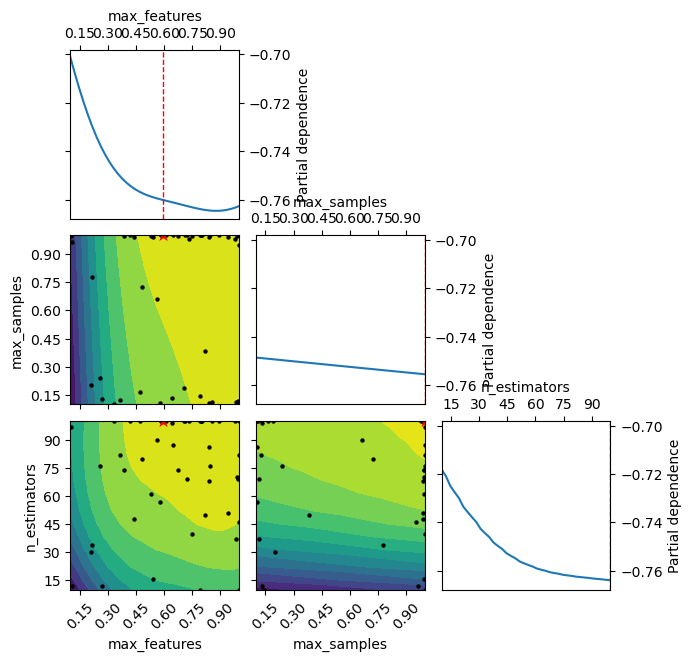

In [50]:
# objective plot
plots.plot_objective(opt.optimizer_results_[0])

array([[<Axes: xlabel='max_features', ylabel='Number of samples'>,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='max_samples'>,
        <Axes: xlabel='max_samples', ylabel='Number of samples'>,
        <Axes: >],
       [<Axes: xlabel='max_features', ylabel='n_estimators'>,
        <Axes: xlabel='max_samples'>,
        <Axes: xlabel='n_estimators', ylabel='Number of samples'>]],
      dtype=object)

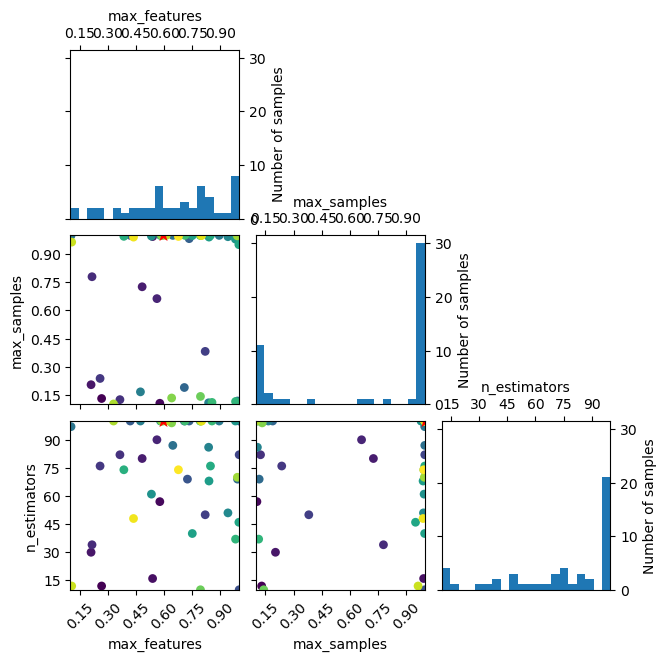

In [51]:
# evaluation plot
plots.plot_evaluations(opt.optimizer_results_[0])

In [52]:
# Random Forest
rf = RandomForestClassifier()
params = {
    'n_estimators': Integer(10, 100),
    'max_depth': Integer(1, 100),
    'min_samples_split': Integer(2, 100),
    'min_samples_leaf': Integer(1, 100)
}
opt = BayesSearchCV(rf, params, n_iter=50, cv=5, scoring='roc_auc', n_jobs=-1)
opt.fit(X_train, y_train)
print("Best params: ", opt.best_params_)
print("Best AUC: %.4f" % opt.best_score_)

Best params:  OrderedDict([('max_depth', 47), ('min_samples_leaf', 3), ('min_samples_split', 8), ('n_estimators', 82)])
Best AUC: 0.7867


array([[<Axes: xlabel='max_depth', ylabel='Partial dependence'>,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='min_samples_leaf'>,
        <Axes: xlabel='min_samples_leaf', ylabel='Partial dependence'>,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='min_samples_split'>, <Axes: >,
        <Axes: xlabel='min_samples_split', ylabel='Partial dependence'>,
        <Axes: >],
       [<Axes: xlabel='max_depth', ylabel='n_estimators'>,
        <Axes: xlabel='min_samples_leaf'>,
        <Axes: xlabel='min_samples_split'>,
        <Axes: xlabel='n_estimators', ylabel='Partial dependence'>]],
      dtype=object)

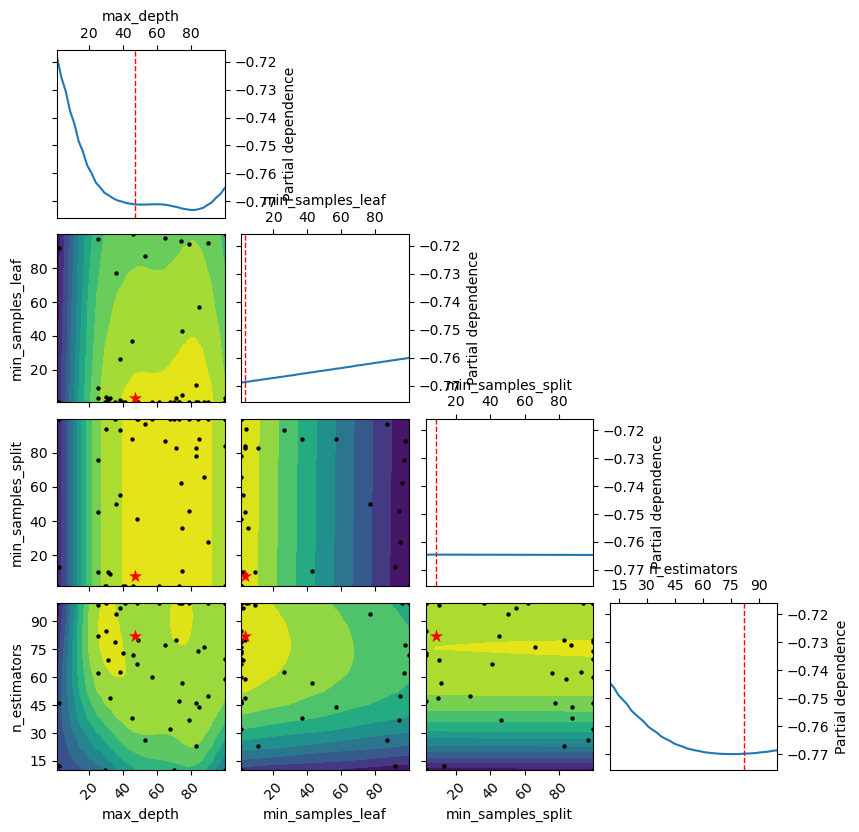

In [53]:
# objective plot
plots.plot_objective(opt.optimizer_results_[0])

array([[<Axes: xlabel='max_depth', ylabel='Number of samples'>, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='min_samples_leaf'>,
        <Axes: xlabel='min_samples_leaf', ylabel='Number of samples'>,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='min_samples_split'>, <Axes: >,
        <Axes: xlabel='min_samples_split', ylabel='Number of samples'>,
        <Axes: >],
       [<Axes: xlabel='max_depth', ylabel='n_estimators'>,
        <Axes: xlabel='min_samples_leaf'>,
        <Axes: xlabel='min_samples_split'>,
        <Axes: xlabel='n_estimators', ylabel='Number of samples'>]],
      dtype=object)

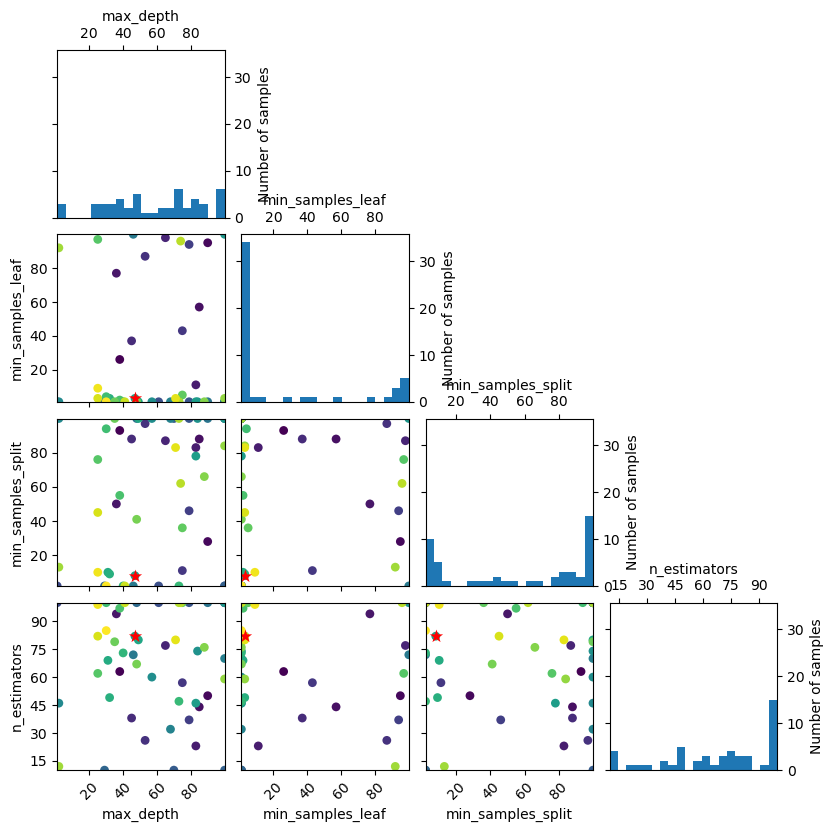

In [54]:
# evaluation plot
plots.plot_evaluations(opt.optimizer_results_[0])

In [99]:
# Gradient Boosting
gb = GradientBoostingClassifier()
params = {
    'n_estimators': Integer(10, 100),
    'learning_rate': Real(1e-6, 1e+1, prior='log-uniform'),
    'max_depth': Integer(1, 100),
    'min_samples_split': Integer(2, 100),
    'min_samples_leaf': Integer(1, 100)
}
opt = BayesSearchCV(gb, params, n_iter=100, cv=5, scoring='roc_auc', n_jobs=-1)
opt.fit(X_train, y_train)
print("Best params: ", opt.best_params_)
print("Best AUC: %.4f" % opt.best_score_)

Best params:  OrderedDict([('learning_rate', 0.030944321621210875), ('max_depth', 78), ('min_samples_leaf', 69), ('min_samples_split', 2), ('n_estimators', 100)])
Best AUC: 0.8058


array([[<Axes: xlabel='learning_rate', ylabel='Partial dependence'>,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='max_depth'>,
        <Axes: xlabel='max_depth', ylabel='Partial dependence'>,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='min_samples_leaf'>, <Axes: >,
        <Axes: xlabel='min_samples_leaf', ylabel='Partial dependence'>,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='min_samples_split'>, <Axes: >, <Axes: >,
        <Axes: xlabel='min_samples_split', ylabel='Partial dependence'>,
        <Axes: >],
       [<Axes: xlabel='learning_rate', ylabel='n_estimators'>,
        <Axes: xlabel='max_depth'>, <Axes: xlabel='min_samples_leaf'>,
        <Axes: xlabel='min_samples_split'>,
        <Axes: xlabel='n_estimators', ylabel='Partial dependence'>]],
      dtype=object)

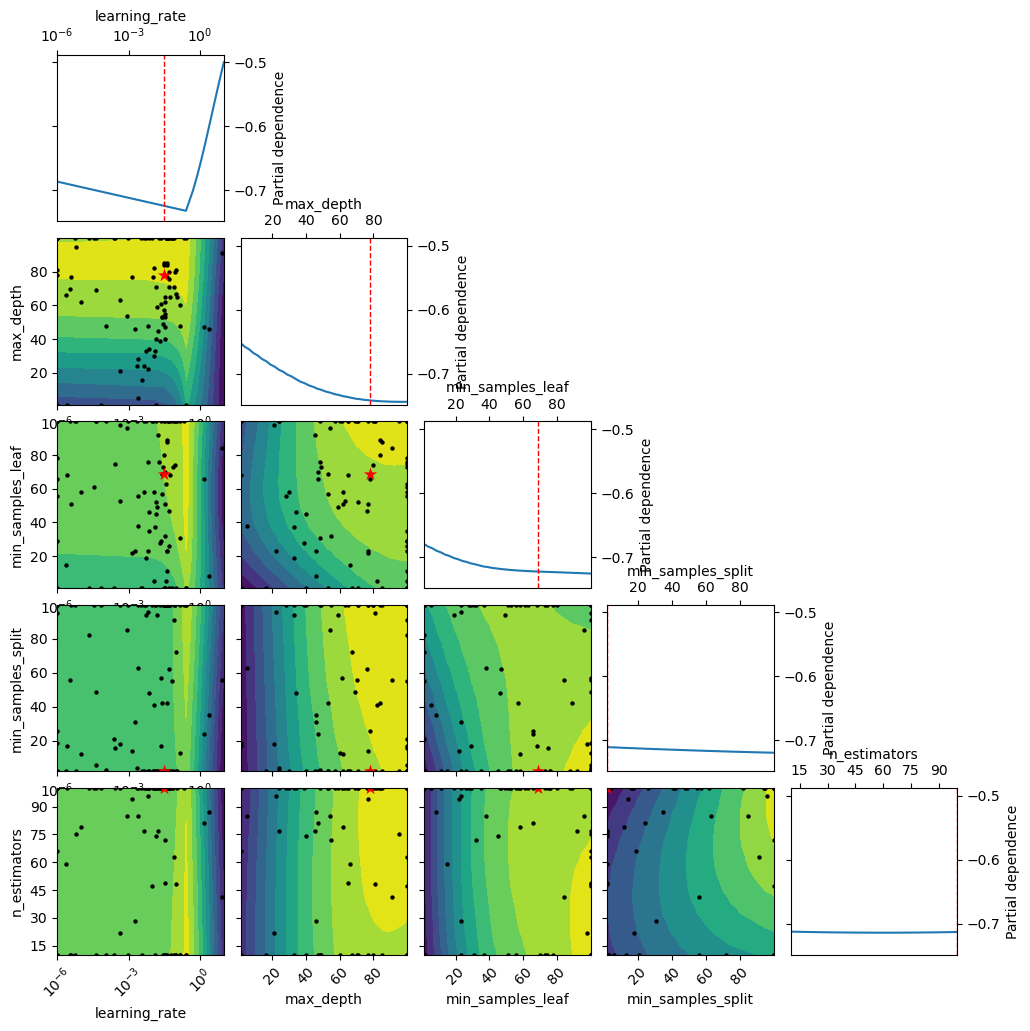

In [101]:
# objective plot
plots.plot_objective(opt.optimizer_results_[0])

array([[<Axes: xlabel='learning_rate', ylabel='Number of samples'>,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='max_depth'>,
        <Axes: xlabel='max_depth', ylabel='Number of samples'>, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='min_samples_leaf'>, <Axes: >,
        <Axes: xlabel='min_samples_leaf', ylabel='Number of samples'>,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='min_samples_split'>, <Axes: >, <Axes: >,
        <Axes: xlabel='min_samples_split', ylabel='Number of samples'>,
        <Axes: >],
       [<Axes: xlabel='learning_rate', ylabel='n_estimators'>,
        <Axes: xlabel='max_depth'>, <Axes: xlabel='min_samples_leaf'>,
        <Axes: xlabel='min_samples_split'>,
        <Axes: xlabel='n_estimators', ylabel='Number of samples'>]],
      dtype=object)

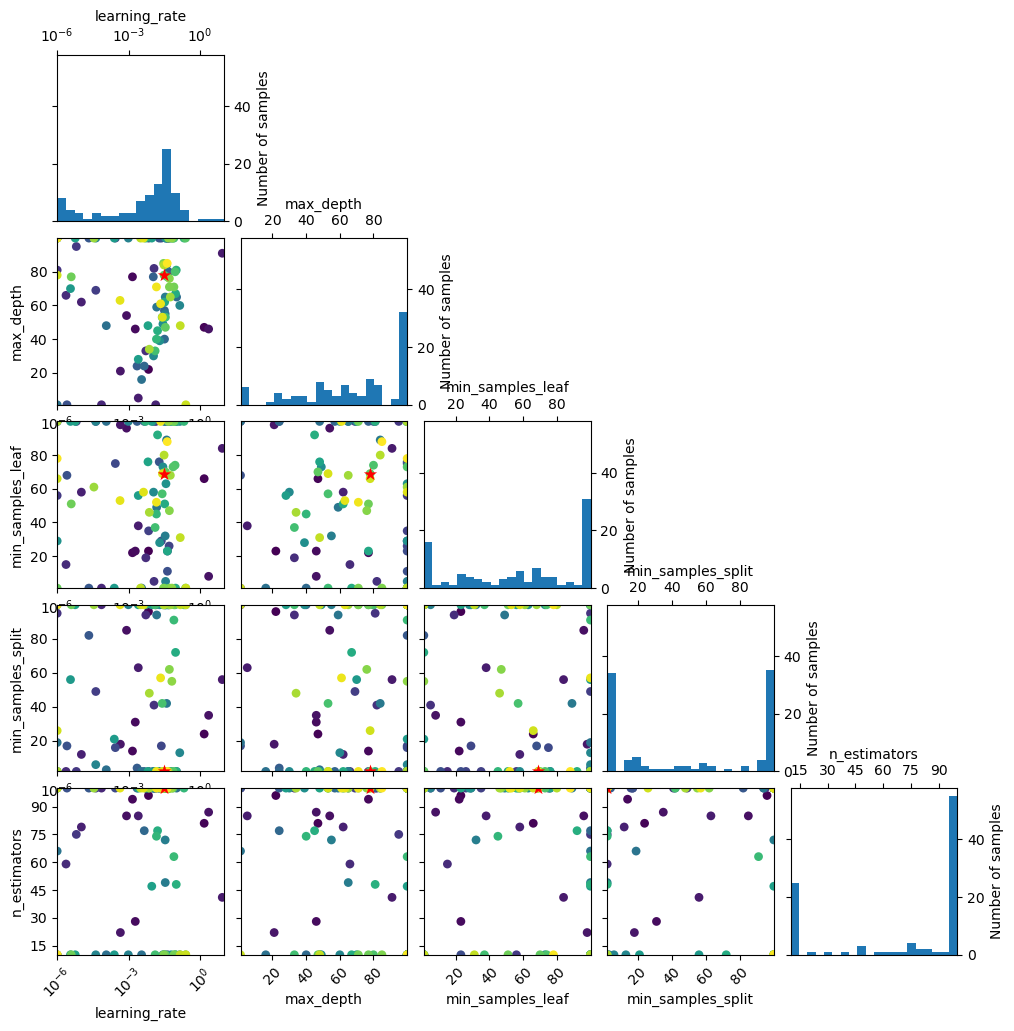

In [102]:
# evaluation plot
plots.plot_evaluations(opt.optimizer_results_[0])

In [58]:
# AdaBoost
ada = AdaBoostClassifier()
params = {
    'n_estimators': Integer(10, 100),
    'learning_rate': Real(1e-6, 1e+1, prior='log-uniform')
}
opt = BayesSearchCV(ada, params, n_iter=50, cv=5, scoring='roc_auc', n_jobs=-1)
opt.fit(X_train, y_train)
print("Best params: ", opt.best_params_)
print("Best AUC: %.4f" % opt.best_score_)

Best params:  OrderedDict([('learning_rate', 0.3745446795636484), ('n_estimators', 92)])
Best AUC: 0.7651


array([[<Axes: xlabel='learning_rate', ylabel='Partial dependence'>,
        <Axes: >],
       [<Axes: xlabel='learning_rate', ylabel='n_estimators'>,
        <Axes: xlabel='n_estimators', ylabel='Partial dependence'>]],
      dtype=object)

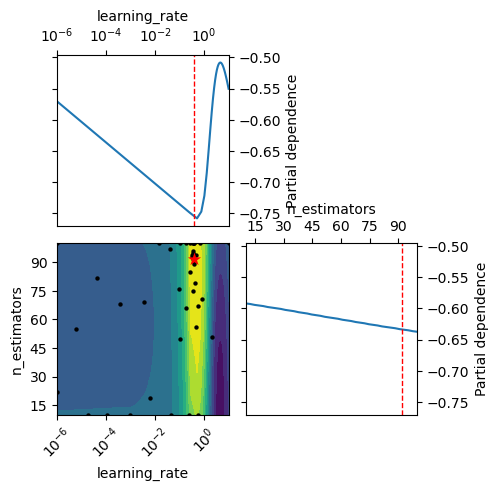

In [59]:
# objective plot
plots.plot_objective(opt.optimizer_results_[0])

array([[<Axes: xlabel='learning_rate', ylabel='Number of samples'>,
        <Axes: >],
       [<Axes: xlabel='learning_rate', ylabel='n_estimators'>,
        <Axes: xlabel='n_estimators', ylabel='Number of samples'>]],
      dtype=object)

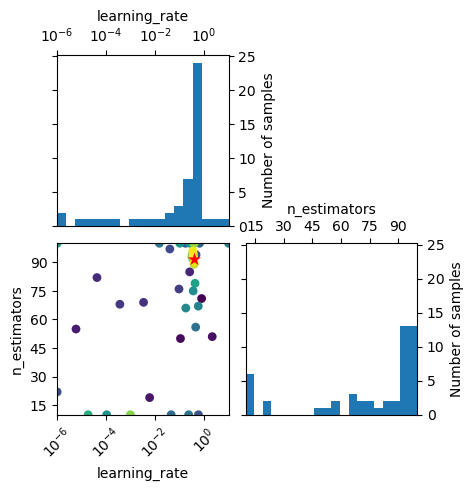

In [60]:
# evaluation plot
plots.plot_evaluations(opt.optimizer_results_[0])

In [132]:
# XGBoost
xgb = XGBClassifier()
params = {
    'n_estimators': Integer(10, 100),
    'learning_rate': Real(1e-6, 1e+1, prior='log-uniform'),
    'max_depth': Integer(1, 100),
    'min_child_weight': Integer(1, 100),
    'subsample': Real(0.1, 1, prior='uniform'),
    'colsample_bytree': Real(0.1, 1, prior='uniform')
}
opt = BayesSearchCV(xgb, params, n_iter=50, cv=5, scoring='roc_auc', n_jobs=-1)
opt.fit(X_train, y_train)
print("Best params: ", opt.best_params_)
print("Best AUC: %.4f" % opt.best_score_)

Best params:  OrderedDict([('colsample_bytree', 0.45027977717347545), ('learning_rate', 8.131268307189035e-06), ('max_depth', 100), ('min_child_weight', 1), ('n_estimators', 100), ('subsample', 1.0)])
Best AUC: 0.9695


In [21]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

# Define the model
xgb = XGBClassifier()

# Define the hyperparameters to tune
params = {
    'n_estimators': Integer(10, 100),
    'learning_rate': Real(1e-6, 1e+1, prior='log-uniform'),
    'max_depth': Integer(1, 100),
    'min_child_weight': Integer(1, 100),
    'subsample': Real(0.1, 1, prior='uniform'),
    'colsample_bytree': Real(0.1, 1, prior='uniform')
}

# Define a custom scorer function
def custom_scorer(estimator, X, y=None):
    estimator.fit(X, y)
    y_pred = estimator.predict_proba(X_valid)[:, 1]
    return roc_auc_score(y_valid, y_pred)

# Use BayesSearchCV with the custom scorer
opt = BayesSearchCV(xgb, params, n_iter=50, scoring=custom_scorer, n_jobs=-1)
opt.fit(X_train, y_train)

print("Best params: ", opt.best_params_)
print("Best AUC: %.4f" % opt.best_score_)

Best params:  OrderedDict([('colsample_bytree', 0.1), ('learning_rate', 0.16810722802530154), ('max_depth', 1), ('min_child_weight', 1), ('n_estimators', 100), ('subsample', 1.0)])
Best AUC: 0.7135


array([[<Axes: xlabel='colsample_bytree', ylabel='Partial dependence'>,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='learning_rate'>,
        <Axes: xlabel='learning_rate', ylabel='Partial dependence'>,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='max_depth'>, <Axes: >,
        <Axes: xlabel='max_depth', ylabel='Partial dependence'>,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='min_child_weight'>, <Axes: >, <Axes: >,
        <Axes: xlabel='min_child_weight', ylabel='Partial dependence'>,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='n_estimators'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: xlabel='n_estimators', ylabel='Partial dependence'>,
        <Axes: >],
       [<Axes: xlabel='colsample_bytree', ylabel='subsample'>,
        <Axes: xlabel='learning_rate'>, <Axes: xlabel='max_depth'>,
        <Axes: xlabel='min_child_weight'>, <Axes: xlabel='n_estimators'>,
        <Axes: xlabel='subsample', y

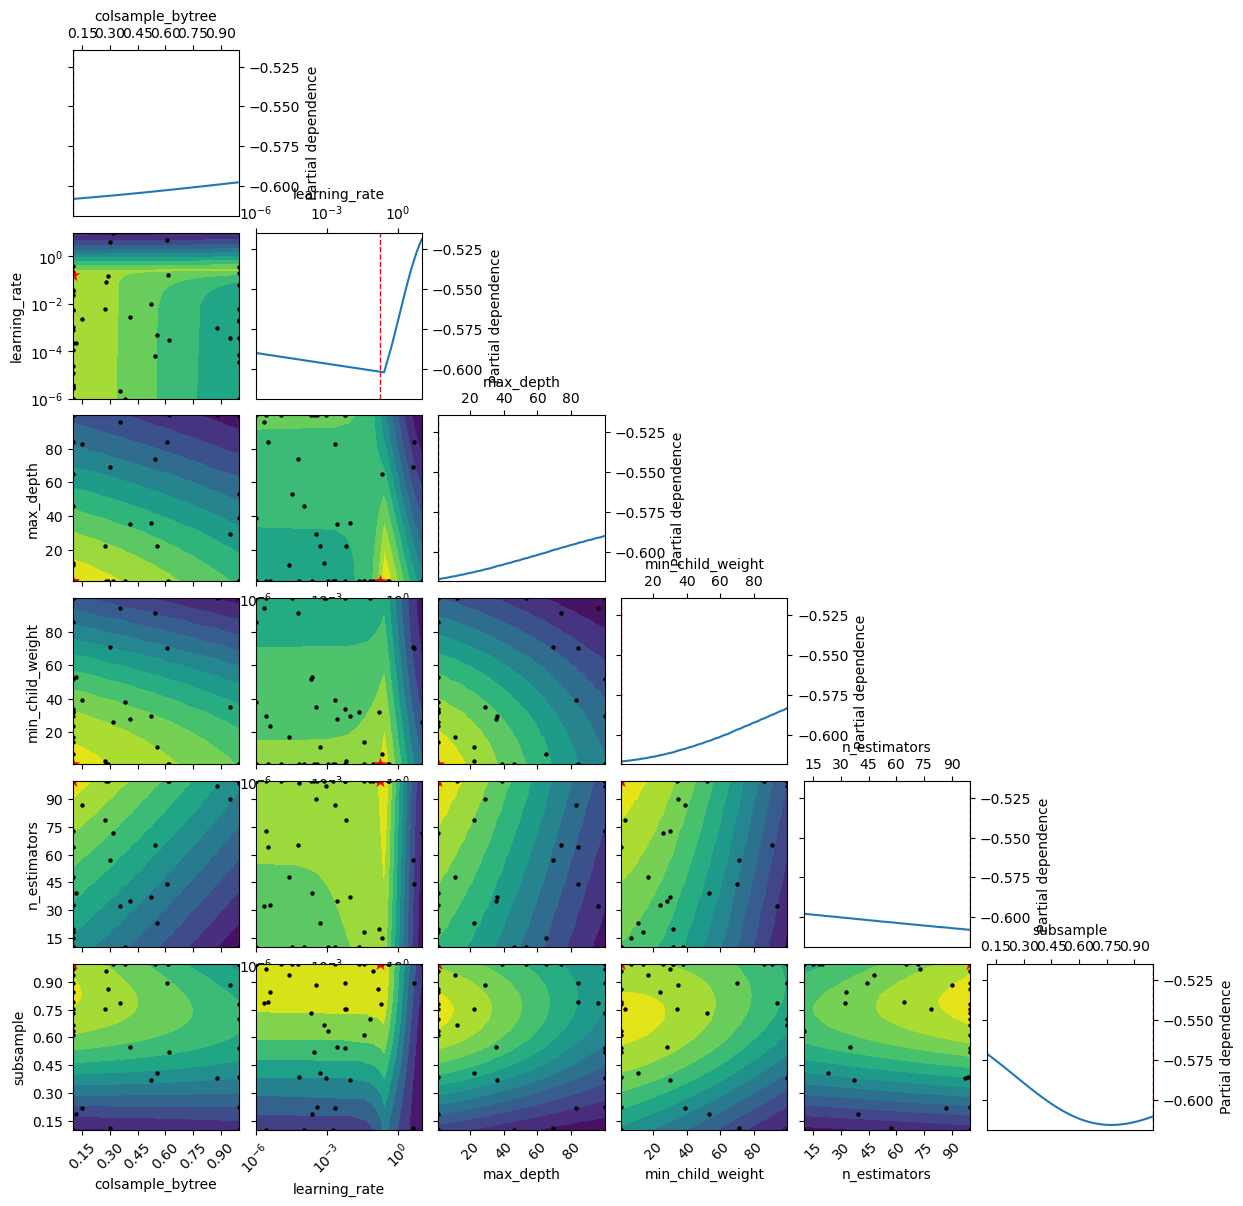

In [23]:
# objective plot
plots.plot_objective(opt.optimizer_results_[0])

array([[<Axes: xlabel='colsample_bytree', ylabel='Number of samples'>,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='learning_rate'>,
        <Axes: xlabel='learning_rate', ylabel='Number of samples'>,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='max_depth'>, <Axes: >,
        <Axes: xlabel='max_depth', ylabel='Number of samples'>, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='min_child_weight'>, <Axes: >, <Axes: >,
        <Axes: xlabel='min_child_weight', ylabel='Number of samples'>,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='n_estimators'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: xlabel='n_estimators', ylabel='Number of samples'>,
        <Axes: >],
       [<Axes: xlabel='colsample_bytree', ylabel='subsample'>,
        <Axes: xlabel='learning_rate'>, <Axes: xlabel='max_depth'>,
        <Axes: xlabel='min_child_weight'>, <Axes: xlabel='n_estimators'>,
        <Axes: xlabel='subsample', ylabel

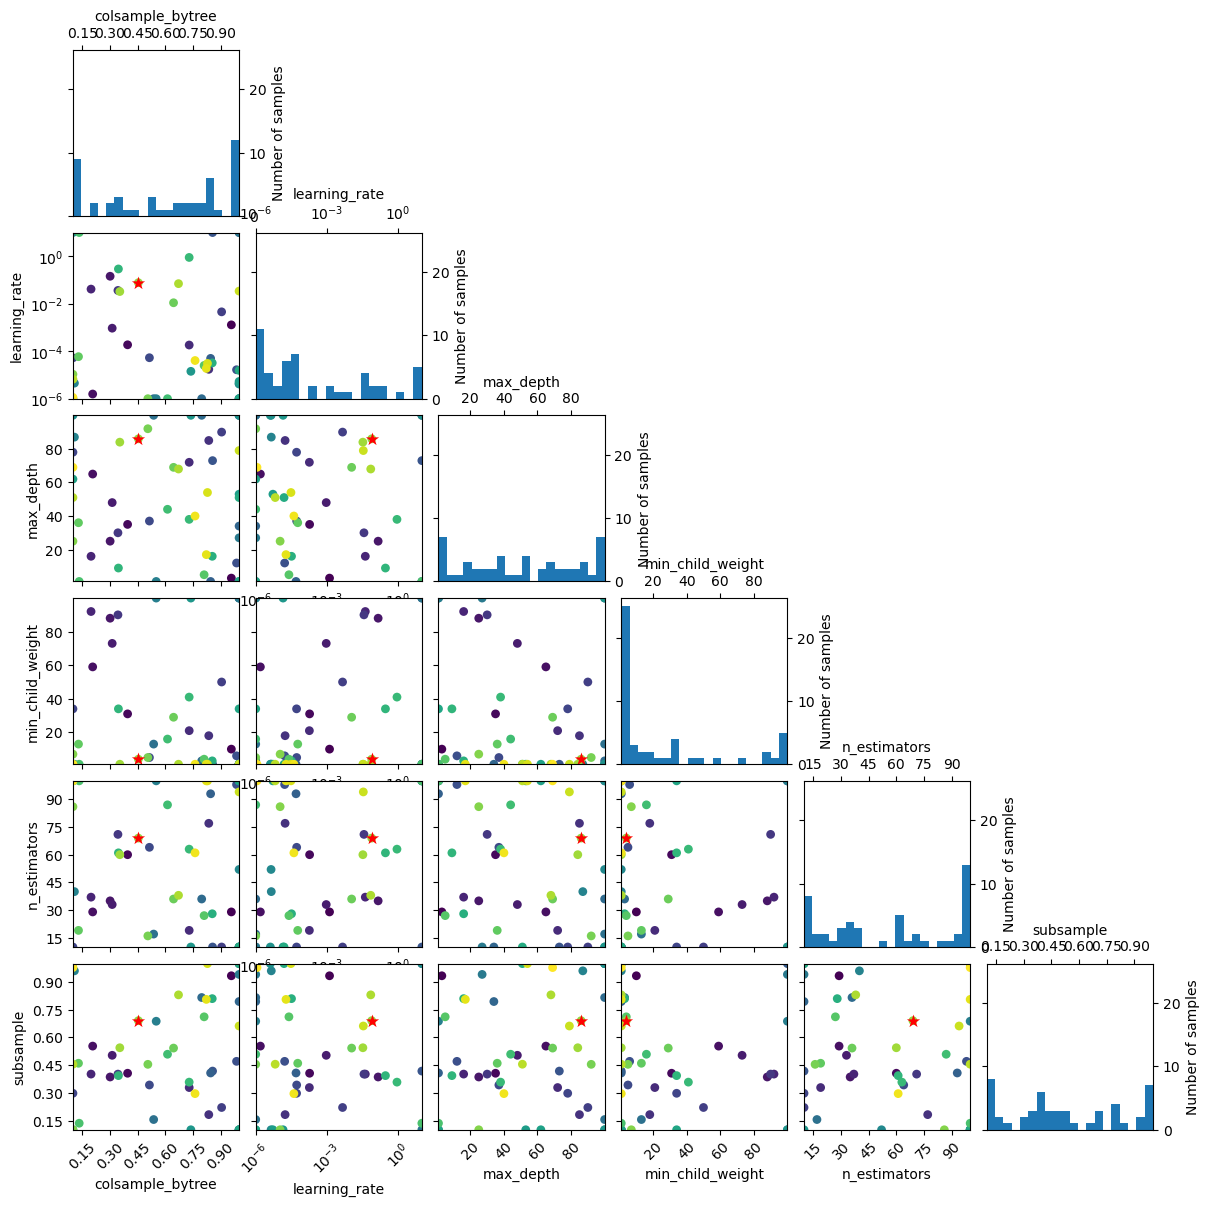

In [98]:
# evaluation plot
plots.plot_evaluations(opt.optimizer_results_[0])

In [ ]:
# predict y_test
y_test = opt.predict(X_test)
pred_df = pd.DataFrame({'id': test['id'], 'readmitted_within_30days': y_test})
# write pred_df
pred_df.to_csv('pred_df.csv', index=False)